# Resources

[Gradient Boosting in Python from Scratch](https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-4a3d9077367)

[CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

[CatBoost VS XGboost - It's Modeling Cat Fight Time!](https://www.youtube.com/watch?v=dvZLk7LxGzc)

[Build a linear model with Estimators - Tensorflow](https://www.tensorflow.org/tutorials/estimator/linear)

[Applying LightGBM to Titanic dataset](https://www.kaggle.com/shep312/applying-lightgbm-to-titanic-dataset)

[XGBoost 2016 Research Paper](http://cinslab.com/wp-content/uploads/2019/06/Ke-Wang-XGBoost-A-Scalable-Tree-Boosting-System.pdf)

[Rain Tomorrow in Aus by XGBoost](https://www.kaggle.com/momincks/rain-tomorrow-in-aus-by-xgboostclassifier/notebook?select=weatherAUS.csv)

[WeatherAUS Modeling](https://www.kaggle.com/hkubra/will-it-rain-tomorrow-eda-fe-modelling)

There isn't no 100% winner in terms of accuracy and performance. Again the advantage is not in the model but in the data

LightGBM in practice works like XGboost but it is faster, it selects only the instances (rows) with the most effect on the gradient (instead than randomly iterating) and then samples the rest.

For many Kaggle-style data mining problems, XGBoost has been the go-to solution since its release in 2016. It's probably as close to an out-of-the-box machine learning algorithm as you can get today, as it gracefully handles un-normalized or missing data, while being accurate and fast to train. 
from: https://bit.ly/3iSnO6d

Catboost does not like missing values. Catboost is best when dealing with a lot of categorical variables

Neural Networks work better than the preivously tested models when an huge amount of ordered and labeled data is available, and there is enough time and knoweldge base to test all the possible network combinations to find the one that fits the data the best

-- To-add via sklearn: k-fold, kNN, Decision Tree, Ramdom Forests, Naive Bayes, SVM

Possible resource: https://www.kaggle.com/minsukheo/titanic-solution-with-sklearn-classifiers

In [ ]:
%matplotlib inline
# When using the 'inline' backend,
# your matplotlib graphs will be included in your notebook, next to the code.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

SEED = 42
TEST_SIZE = 0.1
plt.style.use('dark_background')




---



# Data Titanic

In [ ]:
titanic_df = pd.read_csv('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv')
titanic_df.head()
titanic_df.shape

In [ ]:
titanic_df.loc[titanic_df['Sex'] == 'female','Sex'] = 0
titanic_df.loc[titanic_df['Sex'] == 'male','Sex'] = 1
titanic_df['Sex'] = titanic_df['Sex'].astype('int64')

titanic_df['Alone'] = (titanic_df['Siblings/Spouses Aboard'] == 0) & (titanic_df['Parents/Children Aboard'] == 0)
titanic_df.loc[titanic_df['Alone'] == 'False','Alone'] = 0
titanic_df.loc[titanic_df['Alone'] == 'True','Alone'] = 1
titanic_df['Alone'] = titanic_df['Alone'].astype('int64')
titanic_df.drop('Name', axis=1, inplace=True)
titanic_df.info()

In [ ]:
from sklearn.model_selection import train_test_split

features = [feat for feat in list(titanic_df) if feat != 'Survived']

X_train, X_test, y_train, y_test = train_test_split(titanic_df[features],
                                                    titanic_df[['Survived']],
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED)

X_train.head(3)

In [ ]:
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()
 
plt.show() 

In [ ]:
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, titanic_df['Fare'].max()))
facet.add_legend()
 
plt.xlim(0, 200)
plt.show() 



---



# Catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

# which features are categorical, doesn't always work if by mistake a category is floats
titanic_categories = np.where(titanic_df[features].dtypes != np.float)[0]
# print(features)
# print(titanic_categories)

params = {'loss_function' : 'Logloss', # objective function logistic regression
          'iterations' : 5000,
          'learning_rate' : 0.01,
          'cat_features' : titanic_categories,
          'depth' : 3, # how many features it can have on each tree
          'eval_metric' : 'AUC', # Area Under Curve metric, if we select error numbers will decerase
          'od_type' : 'Iter', # overfit detector, in XGboost it's early stopping
          'od_wait' : 500, # most recent best iteration to wait before stopping
          'verbose' : 200, # output to stdout info of training process every 200 iterations
          'random_seed' : SEED
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train, # data to train on (required parameters, unless we provide X as a pool object)
          eval_set = (X_test, y_test), # data to validate on
          use_best_model = True, # True if we don't want to save trees created after interation within the best validation set
          plot = True) # True for visualization of the training process


In [ ]:
# Confusion Matrix
cat_predictions = np.round(cat_model.predict(X_test))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in cat_predictions])

plt.style.use('dark_background')
plt.figure(figsize = (6, 4))
plt.ticklabel_format(axis = 'y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size' : 16})
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.show()

In [ ]:
# Feature Importance
feat_import = [t for t in zip(features, cat_model.get_feature_importance())]
feat_import_df = pd.DataFrame(feat_import, columns=['Feature', 'VarImp'])
feat_import_df = feat_import_df.sort_values('VarImp', ascending=False)
feat_import_df[feat_import_df['VarImp'] > 0]
feat_import_df



---


# LightGBM



In [ ]:
!pip install lightgbm
import lightgbm as lgbm

In [ ]:
# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass']
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'auc',             # Area under curve as the evaulation metric
    'drop_rate': 0.15
              }

evaluation_results = {}
lgbm_model = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
optimum_boost_rounds = lgbm_model.best_iteration

In [ ]:
# Confusion Matrix
lgbm_predictions = np.round(lgbm_model.predict(X_test))
# dval_predictions

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in lgbm_predictions])

plt.style.use('dark_background')
plt.figure(figsize = (6, 4))
plt.ticklabel_format(axis = 'y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size' : 16})
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('Accuracy score = \t {}'.format(accuracy_score(y_test, lgbm_predictions)))
print('Precision score = \t {}'.format(precision_score(y_test, lgbm_predictions)))
print('Recall score =   \t {}'.format(recall_score(y_test, lgbm_predictions)))
print('F1 score =      \t {}'.format(f1_score(y_test, lgbm_predictions)))



---


#Tensorflow Regression

In [ ]:
!pip install -q sklearn
!pip install tensorflow

In [ ]:
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output

X_train.columns = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses_Aboard', 'Parents/Children_Aboard', 'Fare', 'Alone']
X_test.columns = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses_Aboard', 'Parents/Children_Aboard', 'Fare', 'Alone']

#X_train['Survived'] = y_train
#X_test['Survived'] = y_test

CATEGORICAL_COLUMNS = ['Sex', 'Siblings/Spouses_Aboard', 'Parents/Children_Aboard', 'Pclass', 'Alone']
NUMERIC_COLUMNS = ['Age', 'Fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = X_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [ ]:
ds = make_input_fn(X_train, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['Pclass'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

In [ ]:
age_column = feature_columns[5]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

In [ ]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

In [ ]:
train_input_fn

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.6853933, 'accuracy_baseline': 0.5955056, 'auc': 0.7678197, 'auc_precision_recall': 0.65432996, 'average_loss': 0.5938097, 'label/mean': 0.40449437, 'loss': 0.5782126, 'precision': 0.65384614, 'prediction/mean': 0.34245896, 'recall': 0.4722222, 'global_step': 250}


In [ ]:
age_x_gender = tf.feature_column.crossed_column(['Age', 'Sex'], hash_bucket_size=100)
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.74157304, 'accuracy_baseline': 0.5955056, 'auc': 0.7625786, 'auc_precision_recall': 0.6154431, 'average_loss': 0.74783534, 'label/mean': 0.40449437, 'loss': 0.7468209, 'precision': 0.63829786, 'prediction/mean': 0.51795316, 'recall': 0.8333333, 'global_step': 250}




---


# XGBoost


In [ ]:
!pip install xgboost

In [ ]:
# pivoting categorical date into dummy columns
# for catboost we could just tell it which colunms are categories at it handles it automatically

def prepare_data_for_model(raw_dataframe, target_columns):
  drop_first = True
  make_na_col = True
  dataframe_dummy = pd.get_dummies(raw_dataframe, columns = target_columns,
                                        drop_first = drop_first,
                                        dummy_na = make_na_col)
  return dataframe_dummy

#create dummy features
titanic_df_dummy = prepare_data_for_model(titanic_df, target_columns=['Pclass'])

list(titanic_df_dummy)

['Survived',
 'Sex',
 'Age',
 'Siblings/Spouses Aboard',
 'Parents/Children Aboard',
 'Fare',
 'Alone',
 'Pclass_2.0',
 'Pclass_3.0',
 'Pclass_nan']

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 42 # play around with this variable as it will change train test rows
# we use it to compare catboost and xgboost more fairly
# if not specified it takes it from np.random and train and test data change everytime

features = [feat for feat in list(titanic_df_dummy) if feat != 'Survived']

X_train, X_test, y_train, y_test = train_test_split(titanic_df_dummy[features],
                                                    titanic_df_dummy[['Survived']],
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED)

X_train.head(3)

,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Alone,Pclass_2.0,Pclass_3.0,Pclass_nan
213,1,22.00,1,0,7.7500,0,0,1,0
799,1,0.42,0,1,8.5167,0,0,1,0
431,1,50.00,1,0,55.9000,0,0,0,0


In [ ]:
import xgboost as xgb

xbg_params = {
    'max_depth' : 3,
    'eta' : 0.01, # learning rate
    'silent' : 0,
    'eval_metric': 'auc', # area under curve
    'subsample': 0.8, # randomizes
    'colsample_bytree': 0.8, # randomizes
    'objective' : 'binary:logistic', # logistic regression
    'seed' : SEED
}

#Prepare matrices for XGBoost
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns.values)

evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params = xbg_params,
    dtrain = dtrain,
    num_boost_round = 5000,
    verbose_eval = 200, # how many reports
    early_stopping_rounds = 500,
    evals=evals,
    maximize = True) #auc wants us to up not down

[0]	train-auc:0.856249	eval-auc:0.798742
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 500 rounds.
[200]	train-auc:0.900705	eval-auc:0.816824
[400]	train-auc:0.913774	eval-auc:0.830189
[600]	train-auc:0.923864	eval-auc:0.840933
[800]	train-auc:0.93219	eval-auc:0.847746
[1000]	train-auc:0.939154	eval-auc:0.850891
[1200]	train-auc:0.94488	eval-auc:0.852987
[1400]	train-auc:0.949061	eval-auc:0.849319
Stopping. Best iteration:
[1073]	train-auc:0.941658	eval-auc:0.853512



In [ ]:
# get daframe version of feature importance
xgb_fea_imp = pd.DataFrame(list(xgb_model.get_fscore().items()),
                           columns = ['feature', 'importance']).sort_values('importance', ascending=False)

xgb_fea_imp.head(10)

,feature,importance
1,Fare,3513
5,Age,3337
6,Siblings/Spouses Aboard,734
0,Sex,629
4,Pclass_3.0,435
3,Parents/Children Aboard,337
2,Pclass_2.0,222
7,Alone,116


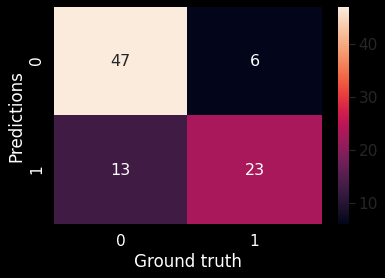

In [ ]:
# Confusion Matrix
xgb_predictions = xgb_model.predict(dtest)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in xgb_predictions])

plt.style.use('dark_background')
plt.figure(figsize = (6, 4))
plt.ticklabel_format(axis = 'y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size' : 16})
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.show()




---



# Titanic AUCs Comparison

In [ ]:
# Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1). 
# AUC provides an aggregate measure of performance across all possible classification thresholds.

# ROC Curve
# Calculate the true positive rate (TPR) and false positive rate (FPR) as we go
# Recall that TPR (TP/TP+FN) and FPR (FP/FP+TN) are defined as follows:
# TPR = True Positives / All Positives
# FPR = False Positives / All negatives
# change tresholds and plot the results

# AUC and accuracy are fairly different things. AUC measures how true positive rate (recall)
# and false positive rate trade off by changes in the classification threshold.

scores = [cat_model.best_score_.get('validation').get('AUC'), xgb_model.best_score, lgbm_model.best_score.get('Test').get('auc'), result.get('auc')]
models = ['Catboost', 'XGBoost', 'LGBM', 'Tensorflow Regression']

import plotly.express as px
fig = px.bar(scores, x=models, y=scores, height=400,width=900, text=list(np.around(np.array(scores),2)), title="Visualization of model comparison")
fig.update_traces(marker_color='rgb(158,20,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()



---



# WeatherAUS Full

In [ ]:
data = pd.read_csv('https://rattle.togaware.com/weatherAUS.csv')
data.drop('RISK_MM', axis=1 ,inplace=True)
data.RainTomorrow = [0 if each=='No' else 1 for each in data.RainTomorrow]
data.RainToday = [0 if each=='No' else 1 for each in data.RainToday]
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data.drop('Date', axis=1 ,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178266 entries, 0 to 178265
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       178266 non-null  object 
 1   MinTemp        175873 non-null  float64
 2   MaxTemp        176112 non-null  float64
 3   Rainfall       173891 non-null  float64
 4   Evaporation    90926 non-null   float64
 5   Sunshine       83237 non-null   float64
 6   WindGustDir    164996 non-null  object 
 7   WindGustSpeed  165091 non-null  float64
 8   WindDir9am     164628 non-null  object 
 9   WindDir3pm     171468 non-null  object 
 10  WindSpeed9am   175271 non-null  float64
 11  WindSpeed3pm   172712 non-null  float64
 12  Humidity9am    174800 non-null  float64
 13  Humidity3pm    171650 non-null  float64
 14  Pressure9am    158813 non-null  float64
 15  Pressure3pm    158826 non-null  float64
 16  Cloud9am       104389 non-null  float64
 17  Cloud3pm       99201 non-null

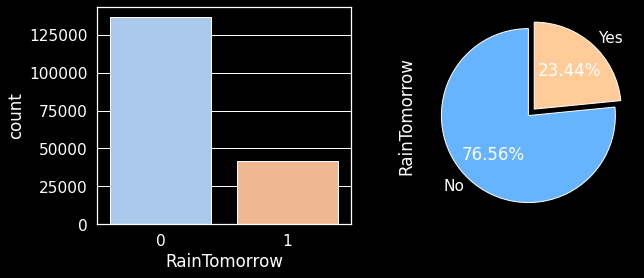

In [ ]:
# The Class Distribution
plt.style.use('dark_background')
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(10,4))
labels=['No', 'Yes']
sns.countplot(x=data.RainTomorrow, data=data, palette="pastel",ax=ax[0])
data['RainTomorrow'].value_counts().plot.pie(autopct="%1.2f%%", ax=ax[1], colors=['#66b3ff','#ffcc99'], 
                                             labels=labels, explode = (0, 0.1), startangle=90)
plt.show()

In [ ]:
def Missing_Values(data):
    variable_name=[]
    total_value=[]
    total_missing_value=[]
    missing_value_rate=[]
    unique_value_list=[]
    total_unique_value=[]
    data_type=[]
    for col in data.columns:
        variable_name.append(col)
        data_type.append(data[col].dtype)
        total_value.append(data[col].shape[0])
        total_missing_value.append(data[col].isnull().sum())
        missing_value_rate.append(round(data[col].isnull().sum()/data[col].shape[0],3))
        unique_value_list.append(data[col].unique())
        total_unique_value.append(len(data[col].unique()))
    missing_data=pd.DataFrame({"Variable":variable_name,"Total_Value":total_value,\
                             "Total_Missing_Value":total_missing_value,"Missing_Value_Rate":missing_value_rate,
                             "Data_Type":data_type,"Unique_Value":unique_value_list,\
                               "Total_Unique_Value":total_unique_value})
    return missing_data.sort_values("Missing_Value_Rate",ascending=False)

In [ ]:
data_info=Missing_Values(data)
data_info.head()

,Variable,Total_Value,Total_Missing_Value,Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
5,Sunshine,178266,95029,0.533,float64,"[nan, 12.3, 13.0, 13.3, 10.6, 12.2, 8.4, 0.0, ...",146
4,Evaporation,178266,87340,0.490,float64,"[nan, 12.0, 14.8, 12.6, 10.8, 11.4, 11.2, 13.0...",372
17,Cloud3pm,178266,79065,0.444,float64,"[nan, 2.0, 8.0, 7.0, 1.0, 5.0, 4.0, 6.0, 3.0, ...",11
16,Cloud9am,178266,73877,0.414,float64,"[8.0, nan, 7.0, 1.0, 0.0, 5.0, 4.0, 2.0, 6.0, ...",11
15,Pressure3pm,178266,19440,0.109,float64,"[1007.1, 1007.8, 1008.7, 1012.8, 1006.0, 1005....",545


In [ ]:
data_info["Scales_of_measurement"]=["Continuous","Continuous","Ordinal","Ordinal","Continuous",\
"Continuous","Nominal","Nominal","Continuous","Nominal","Continuous","Continuous","Continuous",\
"Continuous","Continuous","Nominal","Continuous","Continuous","Continuous","Continuous","Nominal",\
"Nominal","Nominal","Nominal","Nominal"]

data_info = data_info.set_index("Variable")
data_info.head()

,Total_Value,Total_Missing_Value,Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value,Scales_of_measurement
Variable,,,,,,,
Sunshine,178266,95029,0.533,float64,"[nan, 12.3, 13.0, 13.3, 10.6, 12.2, 8.4, 0.0, ...",146,Continuous
Evaporation,178266,87340,0.490,float64,"[nan, 12.0, 14.8, 12.6, 10.8, 11.4, 11.2, 13.0...",372,Continuous
Cloud3pm,178266,79065,0.444,float64,"[nan, 2.0, 8.0, 7.0, 1.0, 5.0, 4.0, 6.0, 3.0, ...",11,Ordinal
Cloud9am,178266,73877,0.414,float64,"[8.0, nan, 7.0, 1.0, 0.0, 5.0, 4.0, 2.0, 6.0, ...",11,Ordinal
Pressure3pm,178266,19440,0.109,float64,"[1007.1, 1007.8, 1008.7, 1012.8, 1006.0, 1005....",545,Continuous


In [ ]:
numerical_columns = list(data_info.loc[(data_info.loc[:,"Scales_of_measurement"]=="Continuous")].index)
len(numerical_columns), numerical_columns

(14,
 ['Sunshine',
  'Evaporation',
  'Pressure3pm',
  'Pressure9am',
  'WindGustSpeed',
  'Humidity3pm',
  'Temp3pm',
  'WindSpeed3pm',
  'Rainfall',
  'Humidity9am',
  'Temp9am',
  'MinTemp',
  'MaxTemp',
  'Year'])

In [ ]:
categorical_columns = list(data_info.loc[(data_info.loc[:,"Scales_of_measurement"]=="Nominal") |
                                       (data_info.loc[:,"Scales_of_measurement"]=="Ordinal")].index)
len(categorical_columns), categorical_columns

(11,
 ['Cloud3pm',
  'Cloud9am',
  'WindDir9am',
  'WindGustDir',
  'WindDir3pm',
  'WindSpeed9am',
  'Month',
  'Location',
  'RainTomorrow',
  'RainToday',
  'Day'])

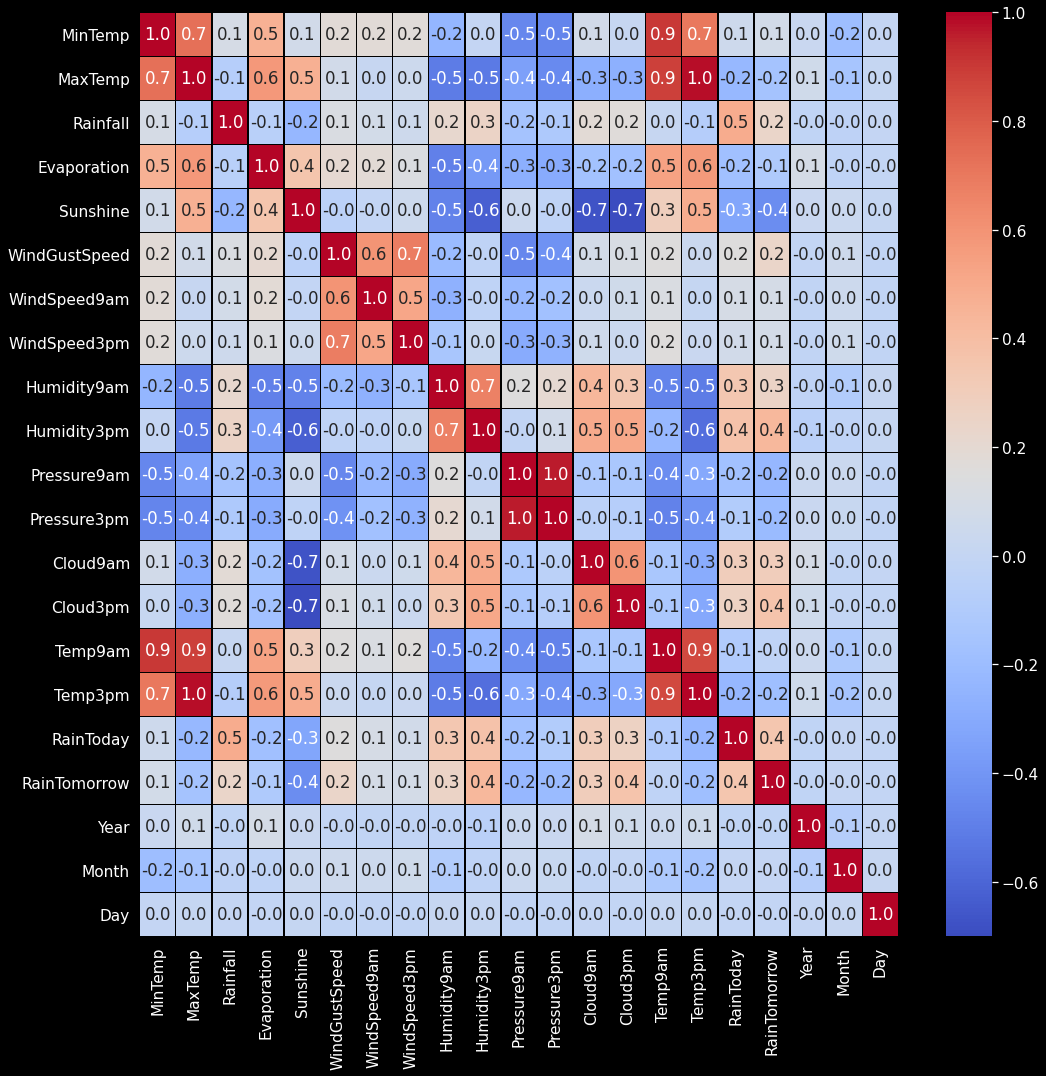

In [ ]:
f,ax = plt.subplots(figsize=(17, 17))
sns.heatmap(data.corr(), annot=True, linewidths=0.5,linecolor="black", fmt= '.1f',ax=ax,cmap="coolwarm")
plt.show()

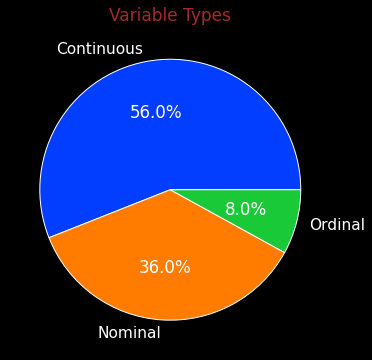

In [ ]:
labels = data_info.Scales_of_measurement.value_counts().index
sizes = data_info.Scales_of_measurement.value_counts().values
plt.figure(figsize = (6,6))
plt.pie(sizes,  labels=labels, colors=sns.color_palette('bright'), autopct='%1.1f%%')
plt.title('Variable Types',fontsize = 17,color = 'brown')
plt.show()

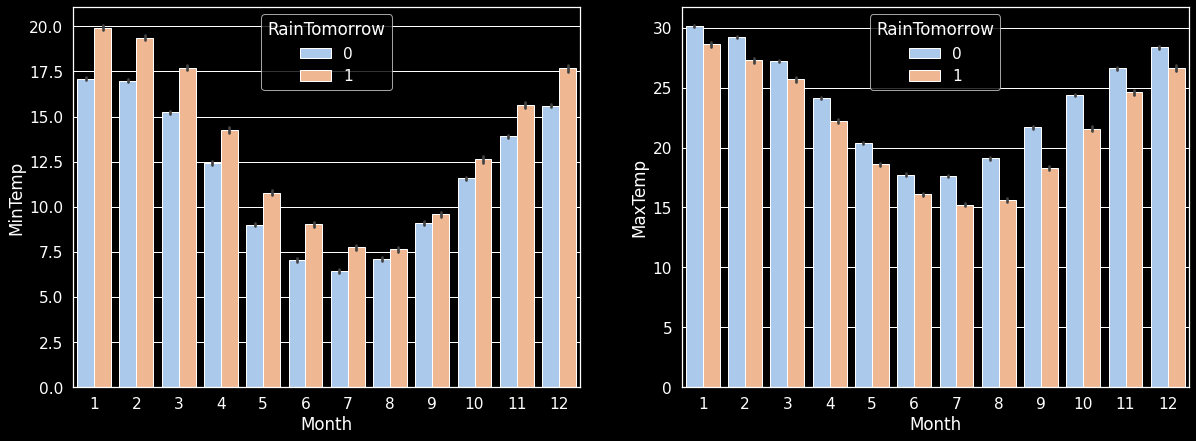

In [ ]:
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(20,7))
sns.barplot(x=data.Month,y=data.MinTemp,hue="RainTomorrow",data=data,ax=ax[0],palette="pastel")
sns.barplot(x=data.Month,y=data.MaxTemp,hue="RainTomorrow",data=data,ax=ax[1],palette="pastel")
plt.show()

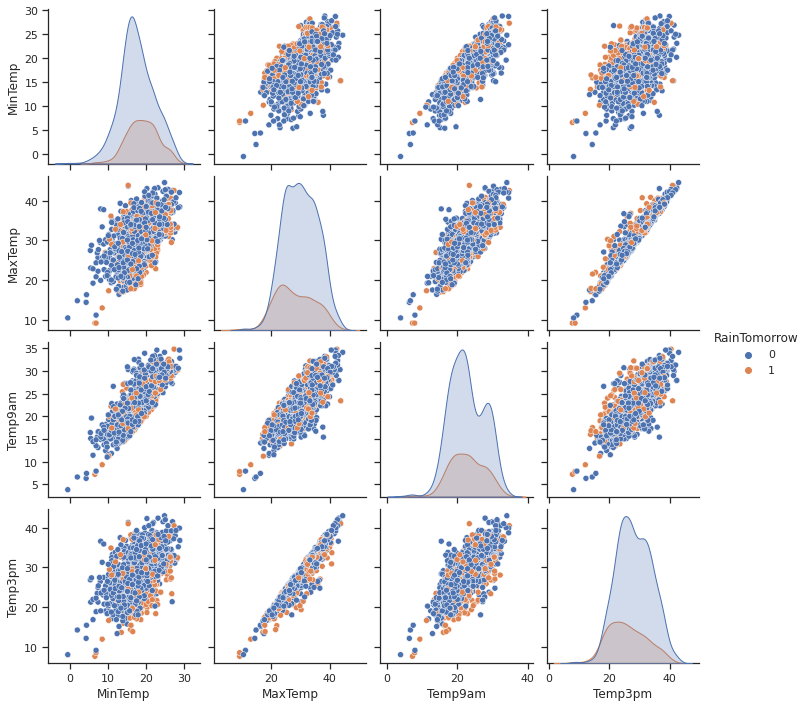

In [ ]:
def pairplot(data,lst):
    sns.set(style="ticks")
    sns.pairplot(data[lst],hue="RainTomorrow")
lst=["MinTemp","MaxTemp","Temp9am","Temp3pm","RainTomorrow"]
data_2016=data[data.Year==2016]
pairplot(data_2016,lst)

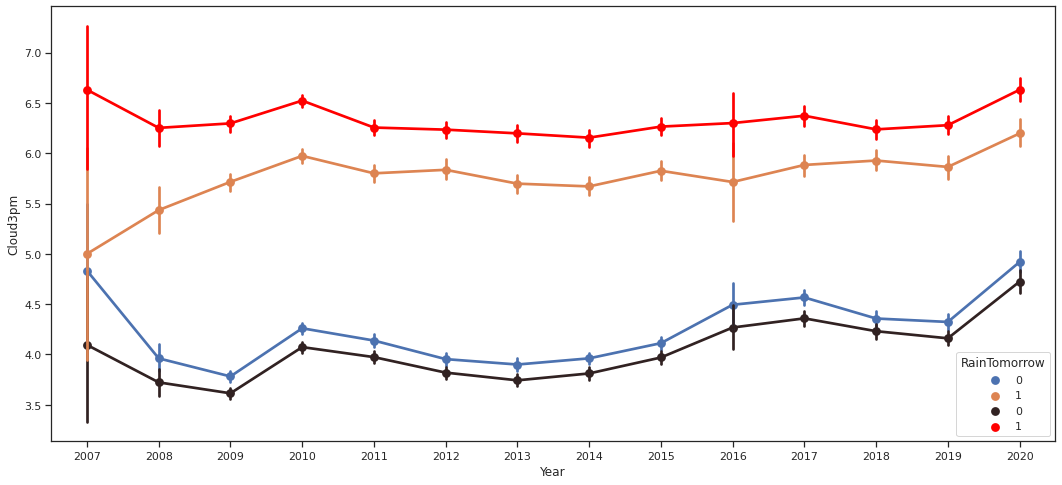

In [ ]:
from plotly.offline import iplot
fig, ax =plt.subplots(nrows=1,ncols=1, figsize=(18,8))
sns.pointplot(x="Year",y="Cloud3pm",data=data,hue="RainToday")
sns.pointplot(x="Year",y="Cloud3pm",data=data,hue="RainTomorrow",color="red")
plt.show()

In [ ]:
x1=data.iloc[:,0:21]
x2=data.iloc[:,22:]
X=pd.concat((x1,x2),axis=1)
Y=data["RainTomorrow"]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
x_train.shape,y_train.shape

((142612, 24), (142612,))

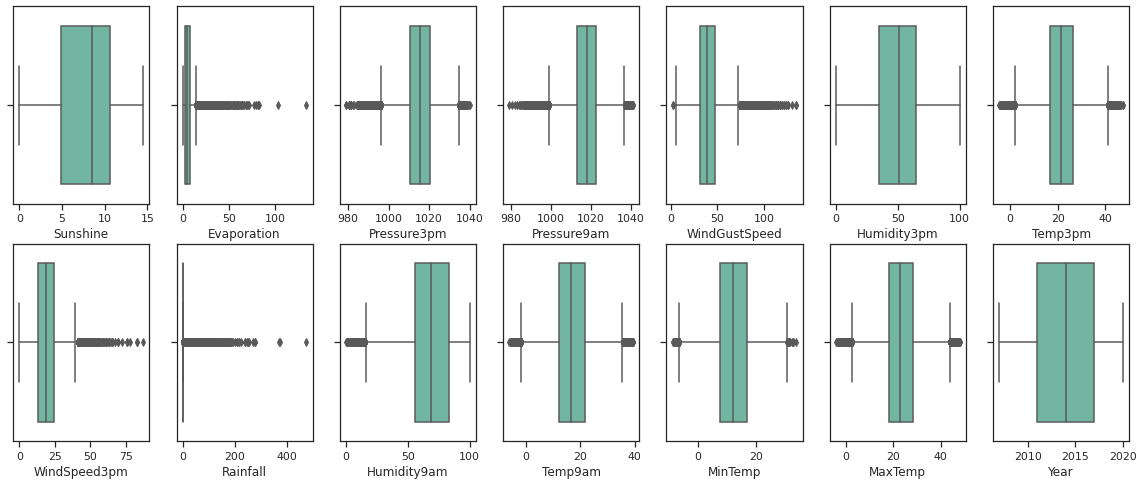

In [ ]:
# Feature engineering

def boxplot_for_outlier(df,columns):
    count = 0
    fig, ax =plt.subplots(nrows=2,ncols=7, figsize=(20,8))
    for i in range(2):
        for j in range(7):
            sns.boxplot(x = df[columns[count]], palette="Set2",ax=ax[i][j])
            count = count+1
boxplot_for_outlier(x_train,numerical_columns)

In [ ]:
#Outlier cleaning for train

lower_and_upper={}
x_train_outlier=x_train.copy()

for col in numerical_columns:
    if(col=="Rainfall"): 
        sparse_value = x_train[col].mode()[0]
        nonsparse_data = pd.DataFrame(x_train[x_train[col] != sparse_value][col])
        q1=nonsparse_data[col].describe()[4]
        q3=nonsparse_data[col].describe()[6]
        iqr=q3-q1
        lowerbound = q1 - (1.5*iqr)
        upperbound = q3 + (1.5*iqr)
        lower_and_upper[col]=(lowerbound,upperbound)
        nonsparse_data.loc[(nonsparse_data.loc[:,col]<lowerbound),col] =  lowerbound*0.75
        nonsparse_data.loc[(nonsparse_data.loc[:,col]>upperbound),col] =  upperbound*1.25
        x_train_outlier[col][nonsparse_data.index]=nonsparse_data[col]
        
    else:
        q1=x_train_outlier[col].describe()[4]
        q3=x_train_outlier[col].describe()[6]
        iqr=q3-q1
        lowerbound = q1 - (1.5 * iqr)
        upperbound = q3 + (1.5 * iqr)
        lower_and_upper[col]=(lowerbound,upperbound)
        number_of_outlier = x_train_outlier.loc[(x_train_outlier.loc[:,col]<lowerbound)\
                                                           | (x_train_outlier.loc[:,col]>upperbound)].shape[0]
        if(number_of_outlier>0):
            print(number_of_outlier," outlier values cleared in" ,col)
            x_train_outlier.loc[(x_train_outlier.loc[:,col]<lowerbound),col] =  lowerbound*0.75
            x_train_outlier.loc[(x_train_outlier.loc[:,col]>upperbound),col] =  upperbound*1.25

2004  outlier values cleared in Evaporation
689  outlier values cleared in Pressure3pm
972  outlier values cleared in Pressure9am
3025  outlier values cleared in WindGustSpeed
848  outlier values cleared in Temp3pm
2459  outlier values cleared in WindSpeed3pm
1184  outlier values cleared in Humidity9am
349  outlier values cleared in Temp9am
67  outlier values cleared in MinTemp
564  outlier values cleared in MaxTemp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Outlier cleaning for test

x_test_outlier=x_test.copy()

for col in numerical_columns:
    if(col =="Rainfall"):
        sparse_value = x_test[col].mode()[0]
        nonsparse_data = pd.DataFrame(x_test[x_test[col] != sparse_value][col])
        nonsparse_data.loc[(nonsparse_data.loc[:,col]<lower_and_upper[col][0]),col] =  lower_and_upper[col][0]*0.75
        nonsparse_data.loc[(nonsparse_data.loc[:,col]>lower_and_upper[col][1]),col] =  lower_and_upper[col][1]*1.25
        x_test_outlier[col][nonsparse_data.index]=nonsparse_data[col]
        
    else:
        
        number_of_outlier_test = x_test_outlier.loc[(x_test_outlier.loc[:,col]<lower_and_upper[col][0]) |\
                                                    (x_test_outlier.loc[:,col]>lower_and_upper[col][1])].shape[0]
        if(number_of_outlier_test>0):
            print(number_of_outlier_test," outlier values cleared in" ,col)
            x_test_outlier.loc[(x_test_outlier.loc[:,col]<lower_and_upper[col][0]),col] =  lower_and_upper[col][0]*0.75
            x_test_outlier.loc[(x_test_outlier.loc[:,col]>lower_and_upper[col][1]),col] =  lower_and_upper[col][1]*1.25

535  outlier values cleared in Evaporation
199  outlier values cleared in Pressure3pm
255  outlier values cleared in Pressure9am
765  outlier values cleared in WindGustSpeed
212  outlier values cleared in Temp3pm
604  outlier values cleared in WindSpeed3pm
286  outlier values cleared in Humidity9am
94  outlier values cleared in Temp9am
17  outlier values cleared in MinTemp
152  outlier values cleared in MaxTemp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



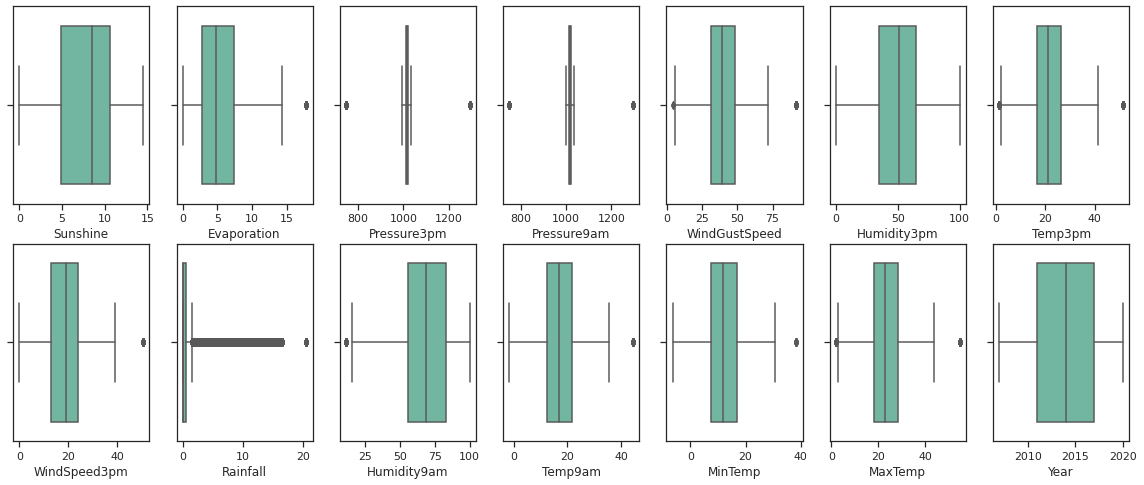

In [ ]:
boxplot_for_outlier(x_train_outlier,numerical_columns)

In [ ]:
# List for low missing values

x_test[numerical_columns]=x_test_outlier[numerical_columns]
x_train[numerical_columns]=x_train_outlier[numerical_columns]

zero_missing_rate=list(data_info[data_info["Missing_Value_Rate"]==0].index)
low_missing_rate=list(data_info[(data_info['Missing_Value_Rate']>0)&(data_info['Missing_Value_Rate']<=0.05)].index)
try:
  low_missing_rate.remove("RainToday")
except:
  pass
low_missing_rate,zero_missing_rate

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(['WindDir3pm',
  'Humidity3pm',
  'Temp3pm',
  'WindSpeed3pm',
  'Rainfall',
  'Humidity9am',
  'WindSpeed9am',
  'Temp9am',
  'MinTemp',
  'MaxTemp'],
 ['Year', 'Month', 'Location', 'RainTomorrow', 'RainToday', 'Day'])

In [ ]:
# Simple Imputer for Low Missing Values

def simple_imputer(data,columns):
    
    for col in columns:
        total_nan=int(data[col].isnull().sum())
        
        if(col in categorical_columns):
            
            most_frequent_value=data[col].value_counts().index[0]
            data[col]=data[col].fillna(most_frequent_value)
            
            print("A total of {} Categorical variable {} have been imputed.".format(total_nan,col))
            
        else:
            mean=data[col].mean()
            std=data[col].std()
            
            random_normal=np.random.normal(loc=mean,scale=std,size=total_nan) 
            data[col][data[col].isnull()]=random_normal
            
            print("A total of {} Numerical variable {} have been imputed.".format(total_nan,col))

simple_imputer(x_train,low_missing_rate)
simple_imputer(x_test,low_missing_rate)

A total of 5426 Categorical variable WindDir3pm have been imputed.
A total of 5273 Numerical variable Humidity3pm have been imputed.
A total of 4477 Numerical variable Temp3pm have been imputed.
A total of 4420 Numerical variable WindSpeed3pm have been imputed.
A total of 3454 Numerical variable Rainfall have been imputed.
A total of 2756 Numerical variable Humidity9am have been imputed.
A total of 2379 Categorical variable WindSpeed9am have been imputed.
A total of 1963 Numerical variable Temp9am have been imputed.
A total of 1915 Numerical variable MinTemp have been imputed.
A total of 1697 Numerical variable MaxTemp have been imputed.
A total of 1372 Categorical variable WindDir3pm have been imputed.
A total of 1343 Numerical variable Humidity3pm have been imputed.
A total of 1152 Numerical variable Temp3pm have been imputed.
A total of 1134 Numerical variable WindSpeed3pm have been imputed.
A total of 921 Numerical variable Rainfall have been imputed.
A total of 710 Numerical varia

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Missing_Values(x_train[low_missing_rate])

,Variable,Total_Value,Total_Missing_Value,Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
0,WindDir3pm,142612,0,0.0,object,"[SSW, NE, NW, SW, WNW, NNW, N, SSE, SE, ESE, W...",16
1,Humidity3pm,142612,0,0.0,float64,"[53.0, 75.0, 58.0, 68.0, 24.0, 44.0, 98.0, 60....",5374
2,Temp3pm,142612,0,0.0,float64,"[15.2, 22.5, 31.0, 9.7, 23.8, 17.5, 12.5, 25.4...",4872
3,WindSpeed3pm,142612,0,0.0,float64,"[9.0, 19.0, 15.0, 11.0, 39.0, 20.0, 24.0, 13.0...",4443
4,Rainfall,142612,0,0.0,float64,"[5.2, 0.0, 7.4, 1.2, 0.2, 2.8, 7.2, 6.2, 13.4,...",3595
5,Humidity9am,142612,0,0.0,float64,"[49.0, 76.0, 81.0, 46.0, 64.0, 98.0, 83.0, 71....",2842
6,WindSpeed9am,142612,0,0.0,float64,"[19.0, 7.0, 6.0, 11.0, 17.0, 28.0, 22.0, 13.0,...",43
7,Temp9am,142612,0,0.0,float64,"[14.9, 21.9, 27.3, 9.4, 18.1, 13.9, 11.3, 21.7...",2337
8,MinTemp,142612,0,0.0,float64,"[5.9, 18.0, 26.1, 3.1, 11.3, 10.7, 17.7, 16.6,...",2289
9,MaxTemp,142612,0,0.0,float64,"[16.4, 24.3, 31.6, 11.9, 24.4, 18.4, 14.0, 26....",2111


In [ ]:
list1=pd.Series(x_train[x_train["RainToday"].isnull()]["Rainfall"])
list2=pd.Series(x_test[x_test["RainToday"].isnull()]["Rainfall"])

x_train["RainToday"].fillna(pd.Series(["Yes" if x>1 else "No" for x in list1],index=list1.index),inplace=True)

x_test["RainToday"].fillna(pd.Series(["Yes" if x>1 else "No" for x in list2],index=list2.index),inplace=True)

Missing_Values(x_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,Variable,Total_Value,Total_Missing_Value,Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
5,Sunshine,142612,75969,0.533,float64,"[nan, 2.5, 9.9, 10.9, 9.5, 10.7, 10.3, 13.3, 6...",146
4,Evaporation,142612,69857,0.490,float64,"[nan, 5.4, 6.6, 5.2, 0.2, 4.6, 2.6, 17.875, 4....",145
17,Cloud3pm,142612,63161,0.443,float64,"[nan, 7.0, 8.0, 1.0, 3.0, 0.0, 4.0, 2.0, 5.0, ...",11
16,Cloud9am,142612,58975,0.414,float64,"[nan, 5.0, 8.0, 0.0, 7.0, 2.0, 4.0, 3.0, 1.0, ...",11
15,Pressure3pm,142612,15474,0.109,float64,"[1023.4, 1021.5, 1009.5, 1024.7, 1014.9, 1025....",390
14,Pressure9am,142612,15479,0.109,float64,"[1023.3, 1025.1, 1013.7, 1027.1, 1019.6, 1028....",383
8,WindDir9am,142612,10868,0.076,object,"[SSW, NE, E, NW, NNE, SW, SE, WSW, nan, WNW, S...",17
6,WindGustDir,142612,10627,0.075,object,"[SSE, nan, NNW, SW, WNW, N, SSW, SE, E, WSW, W...",17
7,WindGustSpeed,142612,10545,0.074,float64,"[30.0, nan, 28.0, 26.0, 24.0, 33.0, 59.0, 31.0...",40
0,Location,142612,0,0.000,object,"[Witchcliffe, Wollongong, Darwin, Portland, Br...",49


In [ ]:
from category_encoders import TargetEncoder

def target_encoder(train,test,columns):
    for col in columns:
        encoder = TargetEncoder()
        train[col]=encoder.fit_transform(train[col],y_train)
        test[col]=encoder.transform(test[col])
        print(test.loc[:,[col]].isnull().sum())
        print(train.loc[:,[col]].isnull().sum())

target_encoder_cols = ["WindDir9am","WindGustDir"]
x_train_encoder=x_train.copy()
x_test_encoder=x_test.copy()
target_encoder(x_train_encoder,x_test_encoder,target_encoder_cols)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



WindDir9am    0
dtype: int64
WindDir9am    0
dtype: int64
WindGustDir    0
dtype: int64
WindGustDir    0
dtype: int64


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [ ]:
data_info_2=Missing_Values(x_train_encoder)
model_based_list=list(data_info_2["Variable"][data_info_2["Missing_Value_Rate"]>0.06])
model_based_list

['Sunshine',
 'Evaporation',
 'Cloud3pm',
 'Cloud9am',
 'Pressure9am',
 'Pressure3pm',
 'WindGustSpeed']

In [ ]:
import time
start_time = time.process_time()

from sklearn.impute import KNNImputer
knn_imputer=KNNImputer(n_neighbors=3)
x_test_mbi=x_test_encoder.copy()
x_train_mbi=x_train_encoder.copy()
for col in model_based_list:
    x_train_mbi[col] = knn_imputer.fit_transform(np.array(x_train_mbi[col]).reshape(-1,1),y_train)
    x_test_mbi[col] = knn_imputer.transform(np.array(x_test_mbi[col]).reshape(-1,1))
    print(x_test_mbi.loc[:,[col]].isnull().sum())
    print(x_train_mbi.loc[:,[col]].isnull().sum())

print((time.process_time()-start_time)/60)

Sunshine    0
dtype: int64
Sunshine    0
dtype: int64
Evaporation    0
dtype: int64
Evaporation    0
dtype: int64
Cloud3pm    0
dtype: int64
Cloud3pm    0
dtype: int64
Cloud9am    0
dtype: int64
Cloud9am    0
dtype: int64
Pressure9am    0
dtype: int64
Pressure9am    0
dtype: int64
Pressure3pm    0
dtype: int64
Pressure3pm    0
dtype: int64
WindGustSpeed    0
dtype: int64
WindGustSpeed    0
dtype: int64
46.08280936443334


In [ ]:
Missing_Values(x_train_mbi)

,Variable,Total_Value,Total_Missing_Value,Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
0,Location,142612,0,0.0,object,"[Witchcliffe, Wollongong, Darwin, Portland, Br...",49
1,MinTemp,142612,0,0.0,float64,"[5.9, 18.0, 26.1, 3.1, 11.3, 10.7, 17.7, 16.6,...",2289
22,Month,142612,0,0.0,int64,"[10, 4, 11, 8, 5, 6, 12, 2, 7, 3, 1, 9]",12
21,Year,142612,0,0.0,int64,"[2010, 2009, 2017, 2015, 2011, 2018, 2012, 201...",14
20,RainToday,142612,0,0.0,int64,"[1, 0]",2
19,Temp3pm,142612,0,0.0,float64,"[15.2, 22.5, 31.0, 9.7, 23.8, 17.5, 12.5, 25.4...",4872
18,Temp9am,142612,0,0.0,float64,"[14.9, 21.9, 27.3, 9.4, 18.1, 13.9, 11.3, 21.7...",2337
17,Cloud3pm,142612,0,0.0,float64,"[4.544914475588728, 7.0, 8.0, 1.0, 3.0, 0.0, 4...",11
16,Cloud9am,142612,0,0.0,float64,"[4.526513385224243, 5.0, 8.0, 0.0, 7.0, 2.0, 4...",11
15,Pressure3pm,142612,0,0.0,float64,"[1023.4, 1021.5, 1009.5, 1024.7, 1014.9, 1025....",390


In [ ]:
from sklearn.preprocessing import LabelEncoder

def Label_Encoder(df,columns,train_or_test):
    for col in columns:
        le = LabelEncoder()
        if(train_or_test == "test"):

            le.fit(x_train_mbi[col].copy().astype(str))
            df[col] = le.transform(df[col].copy().astype(str))

        else:
            df[col] = le.fit_transform(df[col].copy().astype(str))
    return df

x_test_mbi = Label_Encoder(x_test_mbi,["Location","RainToday","WindDir3pm"],"test")
x_train_mbi = Label_Encoder(x_train_mbi,["Location","RainToday","WindDir3pm"],"train")

XGBoost

0.6540576604333334


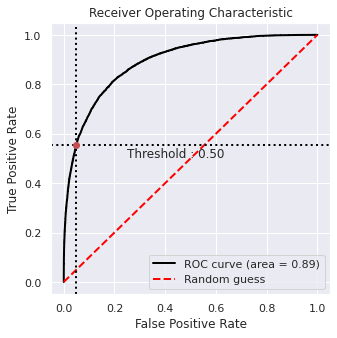

In [ ]:
!pip install plot_metric

from plot_metric.functions import BinaryClassification
import xgboost as xgb
from sklearn import metrics

before_importance_scores=pd.DataFrame(columns=["scores"])

start_time = time.process_time()
xgb_model = xgb.XGBClassifier(n_estimators=150,random_state=0,learning_rate=0.1,eta=0.4,booster="gbtree",base_score=0.8,colsample_bylevel=0.9009229642844634,gamma=0.49967765132613584,
                        max_depth=6,min_child_weight=7,reg_lambda=0.27611902459972926,subsample=0.9300916052594785)

xgb_model.fit(x_train_mbi, y_train)
print((time.process_time()-start_time)/60)
y_pred = xgb_model.predict_proba(x_test_mbi)
y_pred = y_pred[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
before_importance_scores.loc["XGboost Classifier"]=roc_auc

bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

LightGBM

0.261824443949998


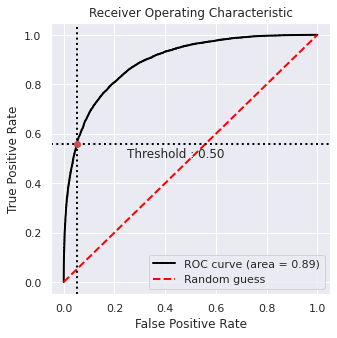

In [ ]:
import lightgbm as lgb

start_time = time.process_time()
lgbm_model = lgb.LGBMClassifier(min_child_samples=25,n_estimators=150,subsample=0.11,
                                boosting_type="dart",learning_rate=0.25)

lgbm_model.fit(x_train_mbi, y_train)
print((time.process_time()-start_time)/60)
y_pred = lgbm_model.predict_proba(x_test_mbi)
y_pred = y_pred[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
before_importance_scores.loc["LGBM Classifier"]=roc_auc


bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

Catboost

4.241975916833334


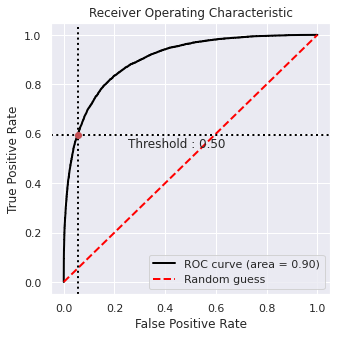

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

start_time = time.process_time()
cat_model = CatBoostClassifier(depth=10,max_bin=60,bagging_temperature= 0.2,random_strength=5)

cat_model.fit(x_train_mbi, y_train,verbose=False)
print((time.process_time()-start_time)/60)
y_pred = cat_model.predict_proba(x_test_mbi)
y_pred = y_pred[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
before_importance_scores.loc["CatBoost Classifier"]=roc_auc

bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

Logistic Regression

4.085560026616667


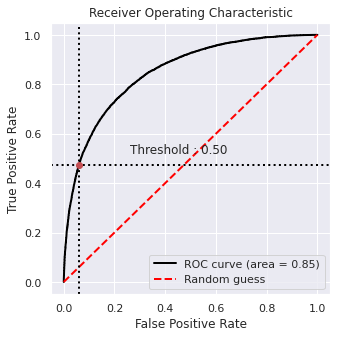

In [ ]:
from sklearn.linear_model import LogisticRegression
start_time = time.process_time()
log_reg_model = LogisticRegression(C= 0.1, solver= 'liblinear',class_weight={1: 0.5, 0: 0.5},penalty="l1")

#log_reg_model.fit(x_train_mbi.dropna(), y_train)
log_reg_model.fit(x_train_mbi.fillna(x_train_mbi.mean()), y_train)
print((time.process_time()-start_time)/60)
y_pred = log_reg_model.predict_proba(x_test_mbi.fillna(x_test_mbi.mean()))
y_pred = y_pred[:, 1]


fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
before_importance_scores.loc["Logistic Regression"]=roc_auc

bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

Feature importance

<Figure size 432x288 with 0 Axes>

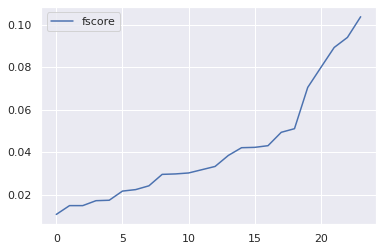

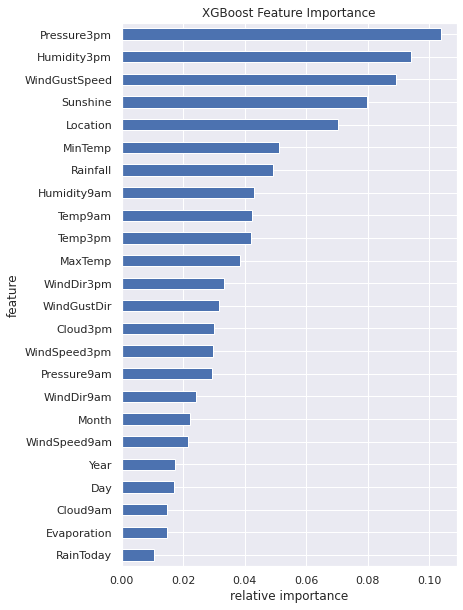

In [ ]:
import operator
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 100 # + 400

dtrain = xgb.DMatrix(x_train_mbi, label=y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()



---



# WeatherAUS AUC Comparison

In [ ]:
# Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1). 
# AUC provides an aggregate measure of performance across all possible classification thresholds.

# ROC Curve
# Calculate the true positive rate (TPR) and false positive rate (FPR) as we go
# Recall that TPR (TP/TP+FN) and FPR (FP/FP+TN) are defined as follows:
# TPR = True Positives / All Positives
# FPR = False Positives / All negatives
# change tresholds and plot the results

# AUC and accuracy are fairly different things. AUC measures how true positive rate (recall)
# and false positive rate trade off by changes in the classification threshold.

import plotly.express as px
fig = px.bar(before_importance_scores, x=before_importance_scores.index, y='scores',height=400,width=900,text=round(before_importance_scores.scores,3),title="Visualization of model comparison")
fig.update_traces(marker_color='rgb(158,20,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()

**Conclusion**

In this project, 4 machine learning algorithms were used. The CatBoost and XGBoost seem to be the best AUC performers by a little difference. The training time of LightGBM algorithm is faster than others. The best among the lower category models, which are regressions perform consistenly worse than gradient boosting models.



---



# Extra: WeatherAUS XGBoost Tuning

In [ ]:
weather_df = pd.read_csv('https://rattle.togaware.com/weatherAUS.csv')
weather_df = weather_df.drop('RISK_MM',axis=1)
weather_df = weather_df.sort_values(by = 'Date')
# weather_df = weather_df.set_index('Date')
# weather_df = weather_df.sort_index()
print(weather_df.isna().sum()) # we don't need to drop the NA as XGBoost handles this for us
# print('Total',len(weather_df.columns),'features\n',weather_df.dtypes)
# weather_df.head()

Date                 0
Location             0
MinTemp           2393
MaxTemp           2154
Rainfall          4375
Evaporation      87340
Sunshine         95029
WindGustDir      13270
WindGustSpeed    13175
WindDir9am       13638
WindDir3pm        6798
WindSpeed9am      2995
WindSpeed3pm      5554
Humidity9am       3466
Humidity3pm       6616
Pressure9am      19453
Pressure3pm      19440
Cloud9am         73877
Cloud3pm         79065
Temp9am           2487
Temp3pm           5629
RainToday         4375
RainTomorrow      4376
dtype: int64


In [ ]:
# Adding some new features, like seasons, semi-annual periods, temperature delta etc.
df = weather_df
df['Month'] = df['Date'].str.slice(start=5,stop=7) # Get Month from Date
df['Date'] = pd.to_datetime(df['Date'],format='%Y/%m/%d',errors='ignore')
df['Season_Q1'] = (df['Month']=='01') | (df['Month']=='02') | (df['Month']=='03')
df['Season_Q2'] = (df['Month']=='04') | (df['Month']=='05') | (df['Month']=='06')
df['Season_Q3'] = (df['Month']=='07') | (df['Month']=='08') | (df['Month']=='09')
df['Year_FirstHalf'] = df['Season_Q1'] | df['Season_Q2']
df['NoRain'] = (df['Rainfall'] == 0)
df['Temp_MinMax'] = df['MaxTemp'] - df['MinTemp']
df['Temp_delta'] = df['Temp3pm'] - df['Temp9am']
df['Humidity_delta'] = df['Humidity3pm'] - df['Humidity9am']
df['WindSpeed_delta'] = df['WindSpeed3pm'] - df['WindSpeed9am']
df['Cloud_delta'] = df['Cloud3pm'] - df['Cloud9am']
df['Pressure_delta'] = df['Pressure3pm'] - df['Pressure9am']
df['NoSunshine'] = (df['Sunshine'] == 0)
df['HighSunshine'] = (df['Sunshine'] >= df['Sunshine'].median())
df['LowHumidity3pm'] = (df['Humidity3pm'] <= df['Humidity3pm'].median())
df['LowCloud3pm'] = (df['Cloud3pm'] <= df['Cloud3pm'].mean())
print(df.dtypes)
print(df.shape)

Date               datetime64[ns]
Location                   object
MinTemp                   float64
MaxTemp                   float64
Rainfall                  float64
Evaporation               float64
Sunshine                  float64
WindGustDir                object
WindGustSpeed             float64
WindDir9am                 object
WindDir3pm                 object
WindSpeed9am              float64
WindSpeed3pm              float64
Humidity9am               float64
Humidity3pm               float64
Pressure9am               float64
Pressure3pm               float64
Cloud9am                  float64
Cloud3pm                  float64
Temp9am                   float64
Temp3pm                   float64
RainToday                  object
RainTomorrow               object
Month                      object
Season_Q1                    bool
Season_Q2                    bool
Season_Q3                    bool
Year_FirstHalf               bool
NoRain                       bool
Temp_MinMax   

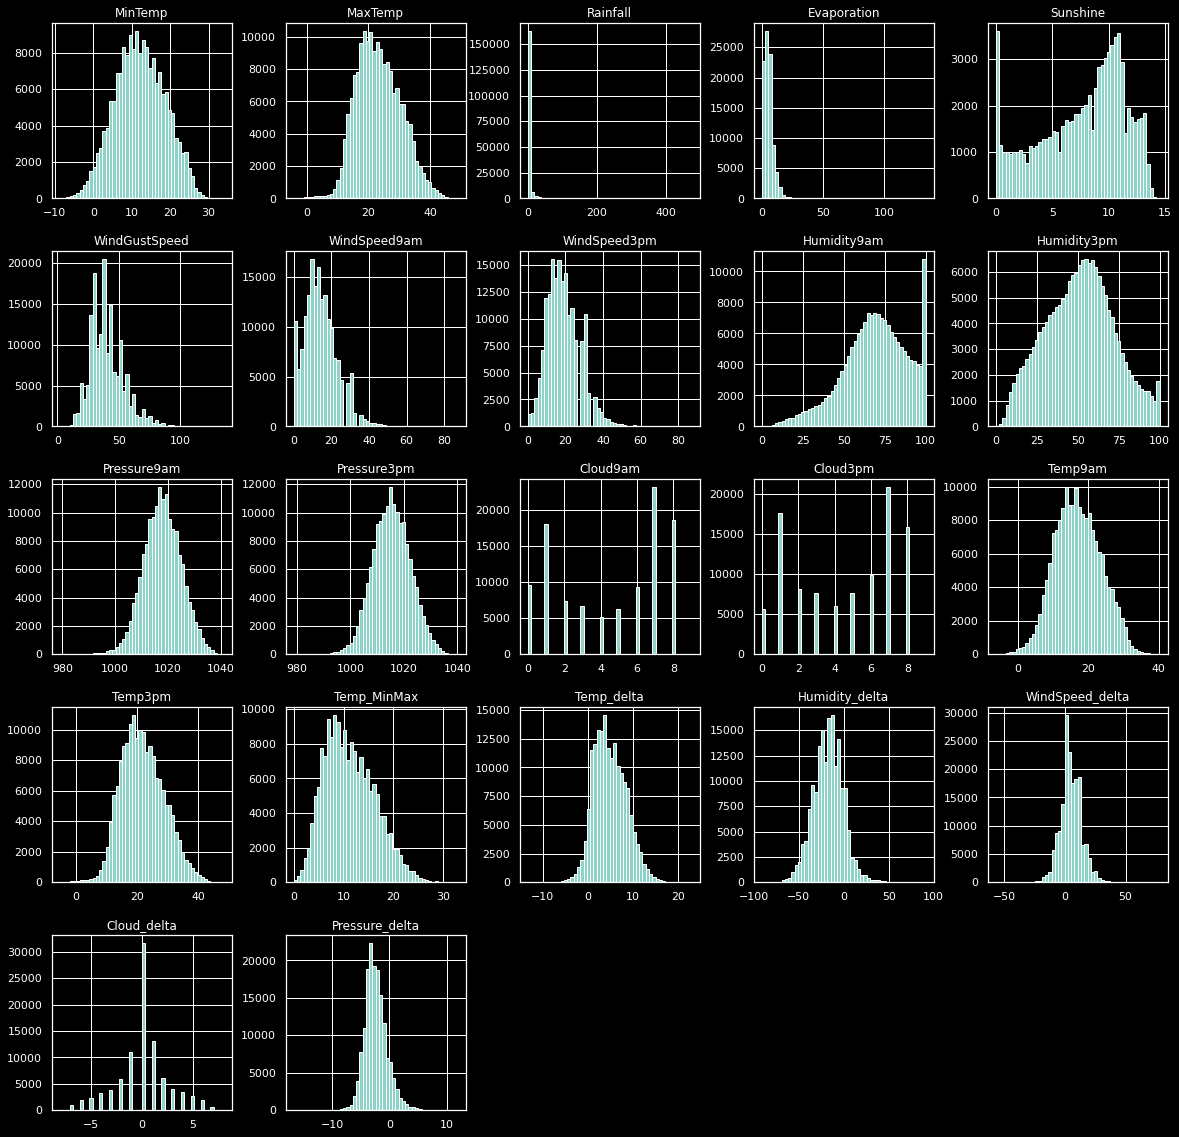

In [ ]:
# Evaporation is one of the features that has significant numbers of outliers.
plt.style.use('dark_background')
df_hist = df.select_dtypes(exclude = ['bool','object'])
df_hist.hist(figsize = [20,20],bins = 50)
plt.show()

In [ ]:
import sklearn.preprocessing as preprocessing

# There are two advantages using QuantileTransformer:
# 1. [0,1] scaling would not be affected by outliers
# 2. Collapse any outlier by setting them to the a priori defined range boundaries of 0 to 1 (check out Rainfall !)

for i in df_hist.columns:
    df[[i]] = preprocessing.StandardScaler().fit_transform(df[[i]])

df['Rainfall'] = df['Rainfall'].apply(lambda x: np.log(x) if x>0 else x)
df['Evaporation'] = df['Evaporation'].apply(lambda x: np.log(x) if x>0 else x)

features_to_transform = ['Evaporation','Humidity9am','Sunshine','Rainfall']
for i in features_to_transform:
    df[[i]] = preprocessing.QuantileTransformer(n_quantiles=100,output_distribution='normal',subsample=len(df)).fit_transform(df[[i]])

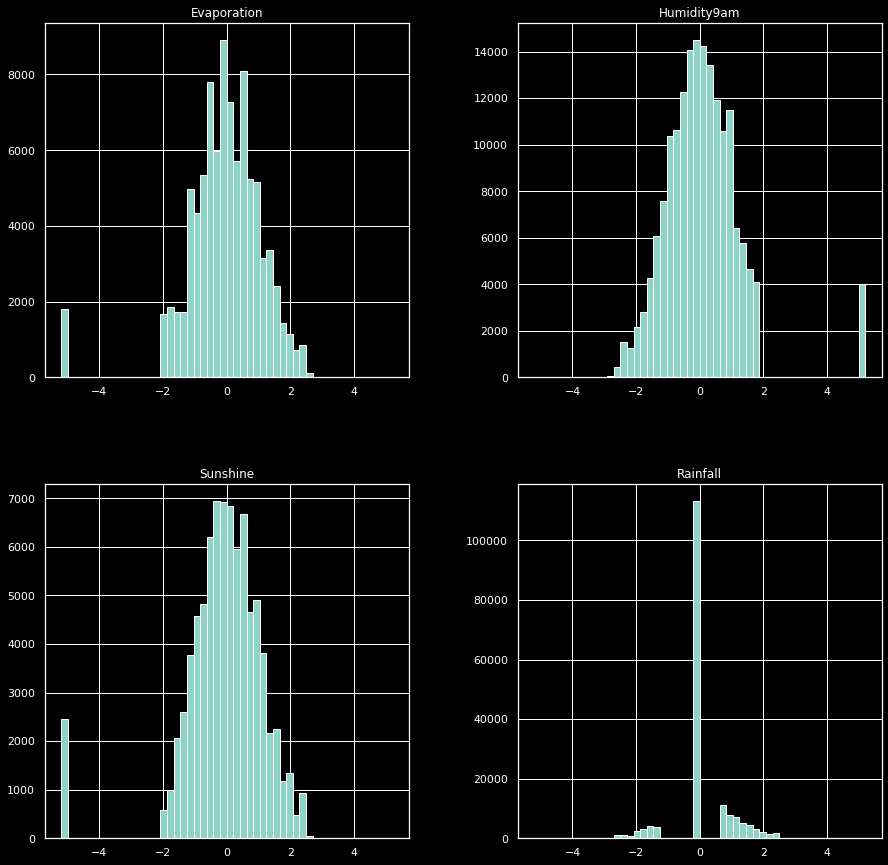

In [ ]:
df_hist = df[features_to_transform]
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [ ]:
# Drop 'Date' and one-hot encode the categorial data using pandas.get_dummies.

df['Humidity9am_transformer'] = (df['Humidity9am']>4)
df['Sunshine_transformer'] = (df['Sunshine']>-4)

features_to_drop = ['Date']
df = df.drop(features_to_drop,axis=1)
remained_categorial_data = ['Month','WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow','Location']
df_onehotted = pd.get_dummies(df,columns=remained_categorial_data,drop_first=True)

# Let's see the top 20 most correlated features with RainTomorrow_Yes.
asc = df_onehotted.corrwith(df_onehotted['RainTomorrow_Yes']).sort_values(ascending=True)[:10]
desc = df_onehotted.corrwith(df_onehotted['RainTomorrow_Yes']).sort_values(ascending=False)[1:11]
print(desc)
print(asc)

Humidity3pm       0.433496
Cloud3pm          0.366854
RainToday_Yes     0.313523
Cloud9am          0.299407
Humidity_delta    0.255092
WindGustSpeed     0.236242
Humidity9am       0.217688
NoSunshine        0.145588
Rainfall          0.107983
Pressure_delta    0.097154
dtype: float64
Sunshine         -0.413597
Temp_MinMax      -0.332660
Temp_delta       -0.321476
LowHumidity3pm   -0.318278
NoRain           -0.285865
Pressure9am      -0.235868
Pressure3pm      -0.210122
HighSunshine     -0.199706
Temp3pm          -0.191562
LowCloud3pm      -0.175364
dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_onehotted.drop(['RainTomorrow_Yes'],axis=1),
                                                    df_onehotted['RainTomorrow_Yes'], test_size = TEST_SIZE, random_state = 0)

In [ ]:


import xgboost as xgb


xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=0.9, colsample_bytree=0.5, gamma=0,
              grow_policy='lossguide', learning_rate=0.4, max_bin=512,
              max_delta_step=0, max_depth=8, min_child_weight=0.8, missing=None,
              n_estimators=100, n_jobs=1, nthread=None, num_parallel_tree=9,
              objective='binary:hinge', random_state=0, reg_alpha=2,
              reg_lambda=3, sampling_method='uniform', scale_pos_weight=1,
              seed=SEED, silent=None, subsample=0.8, tree_method='hist',
              verbosity=1)

xgb.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
# Confusion Matrix
pred = xgb.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, [1 if p > 0.5 else 0 for p in pred])

plt.style.use('dark_background')
plt.figure(figsize = (6, 4))
plt.ticklabel_format(axis = 'y', useOffset=False)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size' : 16})
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.show()

In [ ]:
print('Accuracy',metrics.accuracy_score(y_test, pred))
print('F1 score',metrics.f1_score(y_test, pred))
print('Confusion matrix',metrics.confusion_matrix(y_test, pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
print('AUC: ', metrics.auc(fpr, tpr))

Accuracy 0.8687945251584674
F1 score 0.6339020190953201
Confusion matrix [[13463   608]
 [ 1731  2025]]
AUC:  0.7479639711703973


In [ ]:
# Top 10 features with highest gain and coverage scores.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on
# ‘Coverage’ measures the relative quantity of observations concerned by a feature.”

gain = xgb.get_booster().get_score(importance_type='gain')
gain = pd.DataFrame.from_dict(gain,orient='index',columns=['gain']).sort_values(by=['gain'],ascending=False)[:10]
print(gain.to_string())
cover = xgb.get_booster().get_score(importance_type='cover')
cover = pd.DataFrame.from_dict(cover,orient='index',columns=['cover']).sort_values(by=['cover'],ascending=False)[:10]
print(cover.to_string())

                      gain
LowHumidity3pm  902.611484
HighSunshine    153.430626
Humidity3pm     125.584580
RainToday_Yes    82.962096
NoRain           50.853306
Temp_MinMax      41.023005
LowCloud3pm      38.079224
Sunshine         36.959863
Cloud3pm         24.858000
WindGustSpeed    22.847553
                             cover
LowHumidity3pm        27689.350962
HighSunshine          11117.244472
NoRain                 6889.164939
RainToday_Yes          6722.375221
LowCloud3pm            5754.597859
Humidity3pm            5387.609946
Location_Penrith       4099.565217
Location_Brisbane      3938.917526
Location_Perth         3746.356877
Location_Witchcliffe   3721.806584
